In [1]:
import cv2 
import os

# Buscamos dinámicamente la primera imagen que exista en la carpeta 'gatos'
# Esto evita errores si los nombres cambiaron (ej. gatos_auto_0.jpg)
carpeta_gatos = os.path.join('dataset', 'gatos')

if os.path.exists(carpeta_gatos):
    nombres_archivos = os.listdir(carpeta_gatos)
    
    if len(nombres_archivos) > 0:
        # Tomamos el primer archivo que encuentre
        primera_imagen = nombres_archivos[0] 
        ruta_completa = os.path.join(carpeta_gatos, primera_imagen)

        img = cv2.imread(ruta_completa)

        if img is not None:
            print(f"✅ Éxito leyendo imagen: {primera_imagen}")
            print("Dimensiones detectadas:", img.shape) # Debería ser (64, 64, 3)
        else:
            print("❌ Error: El archivo existe pero cv2 no pudo leerlo.")
    else:
        print("❌ La carpeta 'gatos' está vacía.")
else:
    print("❌ No encuentro la carpeta dataset/gatos.")

✅ Éxito leyendo imagen: gatos_auto_0.jpg
Dimensiones detectadas: (64, 64, 3)


# Convolutional Neural Networks

# Importar Librerías

In [2]:
import numpy as np
import os
import re
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
import keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Flatten
#from keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense, Conv2D
)
from keras.layers import LeakyReLU

# Cargar set de Imágenes

In [4]:
from skimage.transform import resize
dirname = os.path.join(os.getcwd(),'dataset')
imgpath = dirname + os.sep 

images = []
directories = []
dircount = []
prevRoot=''
cant=0

print("leyendo imagenes de ",imgpath)

for root, dirnames, filenames in os.walk(imgpath):
    for filename in filenames:
        if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):
            cant=cant+1
            filepath = os.path.join(root, filename)
            image = plt.imread(filepath)
             #  Convertir en RGB si es en escala de grises
            if len(image.shape) == 2:
                image = np.stack((image,) * 3, axis=-1)

            #  Redimensionar a 64x64 para todas las imágenes
            image = resize(image, (64, 64), anti_aliasing=True, preserve_range=True)

            images.append(image.astype(np.uint8))
            b = "Leyendo..." + str(cant)
            print (b, end="\r")
            if prevRoot !=root:
                print(root, cant)
                prevRoot=root
                directories.append(root)
                dircount.append(cant)
                cant=0
dircount.append(cant)

dircount = dircount[1:]
dircount[0]=dircount[0]+1
print('Directorios leidos:',len(directories))
print("Imagenes en cada directorio", dircount)
print('suma Total de imagenes en subdirs:',sum(dircount))

<>:15: SyntaxWarning: invalid escape sequence '\.'
<>:15: SyntaxWarning: invalid escape sequence '\.'
C:\Users\carlo\AppData\Local\Temp\ipykernel_25240\2848877249.py:15: SyntaxWarning: invalid escape sequence '\.'
  if re.search("\.(jpg|jpeg|png|bmp|tiff)$", filename):


leyendo imagenes de  a:\repositorios github\IA-Proyectos\proyectos\Unidad2\dataset\
a:\repositorios github\IA-Proyectos\proyectos\Unidad2\dataset\gatos 1
a:\repositorios github\IA-Proyectos\proyectos\Unidad2\dataset\hormigas 12157
a:\repositorios github\IA-Proyectos\proyectos\Unidad2\dataset\mariquitas 10000
a:\repositorios github\IA-Proyectos\proyectos\Unidad2\dataset\perros 10000
a:\repositorios github\IA-Proyectos\proyectos\Unidad2\dataset\tortugas 13952
Directorios leidos: 5
Imagenes en cada directorio [12158, 10000, 10000, 13952, 9999]
suma Total de imagenes en subdirs: 56109


# Creamos las etiquetas

In [5]:
labels=[]
indice=0
for cantidad in dircount:
    for i in range(cantidad):
        labels.append(indice)
    indice=indice+1
print("Cantidad etiquetas creadas: ",len(labels))


Cantidad etiquetas creadas:  56109


In [6]:
deportes=[]
indice=0
for directorio in directories:
    name = directorio.split(os.sep)
    print(indice , name[len(name)-1])
    deportes.append(name[len(name)-1])
    indice=indice+1

0 gatos
1 hormigas
2 mariquitas
3 perros
4 tortugas


In [7]:
y = np.array(labels)
X = np.array(images, dtype=np.uint8) #convierto de lista a numpy



# Find the unique numbers from the train labels
classes = np.unique(y)
nClasses = len(classes)
print('Total number of outputs : ', nClasses)
print('Output classes : ', classes)

Total number of outputs :  5
Output classes :  [0 1 2 3 4]


# Creamos Sets de Entrenamiento y Test

In [8]:
train_X,test_X,train_Y,test_Y = train_test_split(X,y,test_size=0.2)
print('Training data shape : ', train_X.shape, train_Y.shape)
print('Testing data shape : ', test_X.shape, test_Y.shape)

Training data shape :  (44887, 64, 64, 3) (44887,)
Testing data shape :  (11222, 64, 64, 3) (11222,)


In [ ]:
from sklearn.utils import class_weight
import numpy as np

# 1. Convertir las etiquetas 'One-Hot' a números enteros (0, 1, 2...)
# Esto es necesario porque 'class_weight' espera una lista simple de clases
y_integers = np.argmax(train_label, axis=1)

# 2. Calcular los pesos automáticamente
# "balanced" le dice: si una clase aparece poco, dale un peso ALTO.
pesos = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_integers),
    y=y_integers
)

# 3. Crear el diccionario que necesita Keras {0: peso, 1: peso...}
class_weights_dict = dict(enumerate(pesos))

print("⚖️ Pesos calculados para equilibrar el entrenamiento:")
for i, peso in class_weights_dict.items():
    print(f"   Clase {deportes[i]}: x{peso:.2f}")

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configuración del Data Augmentation
# Esto creará variaciones infinitas de tus fotos en tiempo real
datagen = ImageDataGenerator(
    rotation_range=20,      # Rotar hasta 20 grados
    width_shift_range=0.1,  # Mover horizontalmente 10%
    height_shift_range=0.1, # Mover verticalmente 10%
    shear_range=0.1,        # Inclinación
    zoom_range=0.1,         # Zoom
    horizontal_flip=True,   # Espejo horizontal
    fill_mode='nearest'
)

# Calculamos las estadísticas necesarias usando tus datos de entrenamiento
datagen.fit(train_X)
print("✅ Generador de imágenes configurado.")

✅ Generador de imágenes configurado.


Text(0.5, 1.0, 'Ground Truth : 1')

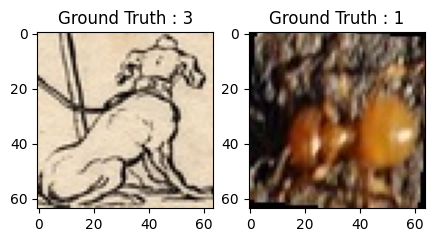

In [10]:
plt.figure(figsize=[5,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(train_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(train_Y[0]))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(test_X[0,:,:], cmap='gray')
plt.title("Ground Truth : {}".format(test_Y[0]))

# Preprocesamos las imagenes

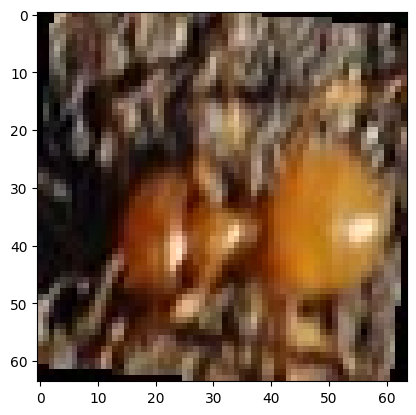

In [11]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
train_X = train_X/255.
test_X = test_X/255.
plt.imshow(test_X[0,:,:])

## Hacemos el One-hot Encoding para la red

In [12]:
# Change the labels from categorical to one-hot encoding
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

# Display the change for category label using one-hot encoding
print('Original label:', train_Y[0])
print('After conversion to one-hot:', train_Y_one_hot[0])

Original label: 3
After conversion to one-hot: [0. 0. 0. 1. 0.]


# Creamos el Set de Entrenamiento y Validación

In [13]:
#Mezclar todo y crear los grupos de entrenamiento y testing
train_X,valid_X,train_label,valid_label = train_test_split(train_X, train_Y_one_hot, test_size=0.2, random_state=13)

In [14]:
print(train_X.shape,valid_X.shape,train_label.shape,valid_label.shape)

(35909, 64, 64, 3) (8978, 64, 64, 3) (35909, 5) (8978, 5)


# Creamos el modelo de CNN

In [15]:
#declaramos variables con los parámetros de configuración de la red
INIT_LR = 1e-3 # Valor inicial de learning rate. El valor 1e-3 corresponde con 0.001
epochs = 20 # Cantidad de iteraciones completas al conjunto de imagenes de entrenamiento
batch_size = 64 # cantidad de imágenes que se toman a la vez en memoria

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

sport_model = Sequential([
    Input(shape=(64, 64, 3)),
    
    # Bloque 1
    Conv2D(32, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Dropout(0.2), # Freno suave (20%)

    # Bloque 2
    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Dropout(0.2), 

    # Bloque 3
    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Dropout(0.3), # Freno medio (30%)

    # Bloque 4 (El más grande)
    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),
    Dropout(0.4), # Freno fuerte (40%) antes de aplanar

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5), # Freno máximo (50%) en las neuronas finales
    Dense(nClasses, activation='softmax')
])

# Compilamos con una tasa de aprendizaje (learning rate) un poco más baja para ser precisos
from tensorflow.keras.optimizers import Adam
sport_model.compile(optimizer=Adam(learning_rate=0.0005), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

sport_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,438,533 (5.49 MB)

 Trainable params: 1,438,533 (5.49 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
sport_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,048,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,438,533 (5.49 MB)

 Trainable params: 1,438,533 (5.49 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
from tensorflow.keras.optimizers import Adam

# Bajamos la velocidad inicial a 0.0005 para ser más cautelosos al principio
sport_model.compile(optimizer=Adam(learning_rate=0.0005), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy'])

print("✅ Modelo compilado con Learning Rate inicial de 0.0005")

✅ Modelo compilado con Learning Rate inicial de 0.0005


# Entrenamos el modelo: Aprende a clasificar imágenes

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1. Configurar los Callbacks (Las reglas del entrenamiento)
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10,                # Espera 10 épocas antes de rendirse
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,                 # Si te estancas, baja la velocidad a la mitad
    patience=4,                 # Espera 4 épocas antes de bajar la velocidad
    min_lr=0.00001, 
    verbose=1
)

print("🚀 Iniciando entrenamiento con Pesos de Clase (Sin clones)...")

# 2. Entrenar usando 'class_weight'
sport_train = sport_model.fit(
    datagen.flow(train_X, train_label, batch_size=32), # Batch 32 es más estable para datasets pequeños
    epochs=40,
    verbose=1,
    validation_data=(valid_X, valid_label),
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights_dict   # <--- ¡ESTO ES LO NUEVO E IMPORTANTE!
)

print("🏁 Entrenamiento finalizado.")

🚀 Iniciando entrenamiento (Con Data Augmentation + ReduceLR)...
Epoch 1/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 134s 232ms/step - accuracy: 0.4898 - loss: 1.1287 - val_accuracy: 0.6264 - val_loss: 0.8368 - learning_rate: 5.0000e-04
Epoch 2/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 154s 254ms/step - accuracy: 0.6303 - loss: 0.8209 - val_accuracy: 0.6985 - val_loss: 0.6779 - learning_rate: 5.0000e-04
Epoch 3/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 129s 230ms/step - accuracy: 0.6804 - loss: 0.7221 - val_accuracy: 0.7130 - val_loss: 0.6525 - learning_rate: 5.0000e-04
Epoch 4/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 133s 237ms/step - accuracy: 0.7055 - loss: 0.6597 - val_accuracy: 0.7429 - val_loss: 0.5779 - learning_rate: 5.0000e-04
Epoch 5/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 142s 252ms/step - accuracy: 0.7228 - loss: 0.6201 - val_accuracy: 0.7443 - val_loss: 0.5727 - learning_rate: 5.0000e-04
Epoch 6/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 133s 237ms/step - accuracy: 0.7384 - loss: 0.5874 - val_accuracy: 0.7518 - val_loss: 0.5584 - le

In [20]:
# guardamos la red, para reutilizarla en el futuro, sin tener que volver a entrenar
sport_model.save("animales2.h5")

# Evaluamos la red

In [21]:
test_eval = sport_model.evaluate(test_X, test_Y_one_hot, verbose=1)

351/351 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.8470 - loss: 0.3599


In [22]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.3599437475204468
Test accuracy: 0.8469969630241394


In [23]:
sport_train.history

{'accuracy': [0.48979365825653076,
  0.6303155422210693,
  0.6804143786430359,
  0.7055334448814392,
  0.7227993011474609,
  0.738366425037384,
  0.7499791383743286,
  0.7559664845466614,
  0.7645715475082397,
  0.7739564180374146,
  0.7850121259689331,
  0.793867826461792,
  0.7963463068008423,
  0.8014982342720032,
  0.8045893907546997,
  0.8085716962814331,
  0.8080982565879822,
  0.8092400431632996,
  0.8133615255355835,
  0.8147539496421814,
  0.8209640979766846,
  0.827229917049408,
  0.82594895362854,
  0.827229917049408,
  0.8309337496757507,
  0.8290122151374817,
  0.8332451581954956,
  0.8348881602287292,
  0.8380072116851807,
  0.8383135199546814,
  0.8361691832542419,
  0.8384527564048767,
  0.8392046689987183,
  0.841850221157074,
  0.844245195388794,
  0.8430476784706116,
  0.8448299765586853,
  0.8451363444328308],
 'loss': [1.1287226676940918,
  0.8209158778190613,
  0.7221405506134033,
  0.6597036123275757,
  0.6200825572013855,
  0.5874181985855103,
  0.56067389249801

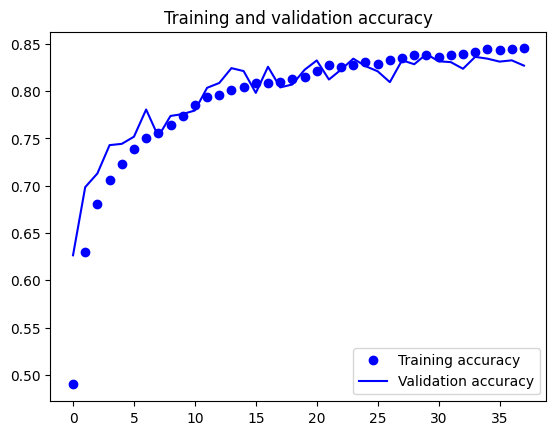

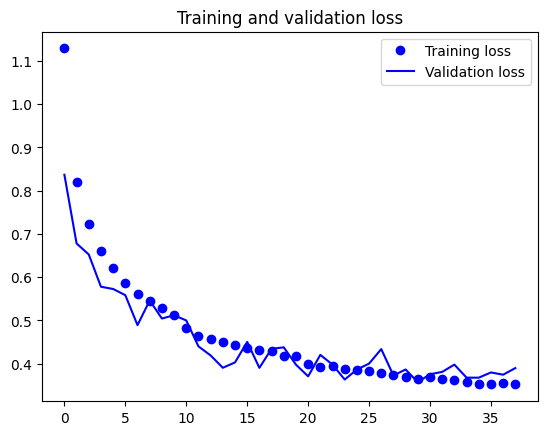

In [24]:
accuracy = sport_train.history['accuracy']
val_accuracy = sport_train.history['val_accuracy']
loss = sport_train.history['loss']
val_loss = sport_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
predicted_classes2 = sport_model.predict(test_X)

351/351 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step


In [26]:
predicted_classes=[]
for predicted_sport in predicted_classes2:
    predicted_classes.append(predicted_sport.tolist().index(max(predicted_sport)))
predicted_classes=np.array(predicted_classes)

In [27]:
predicted_classes.shape, test_Y.shape

((11222,), (11222,))

# Aprendamos de los errores: Qué mejorar

Found 9505 correct labels


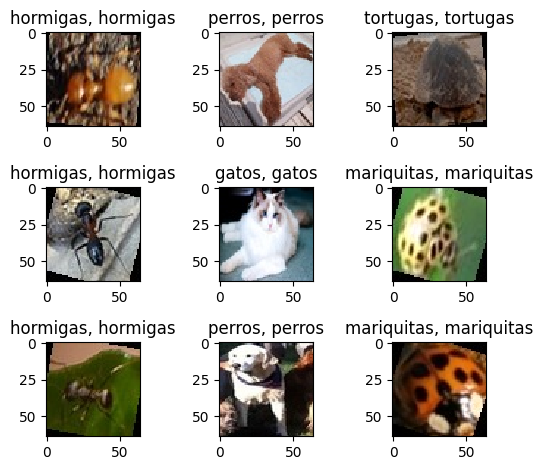

In [28]:
correct = np.where(predicted_classes==test_Y)[0]
print("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[0:9]):
    plt.subplot(3,3,i+1)
    
    # --- AQUÍ ESTÁ EL CAMBIO: (64, 64, 3) ---
    plt.imshow(test_X[correct].reshape(64,64,3), cmap='gray', interpolation='none')
    
    plt.title("{}, {}".format(deportes[predicted_classes[correct]],
                                                    deportes[test_Y[correct]]))

    plt.tight_layout()

Found 1717 incorrect labels


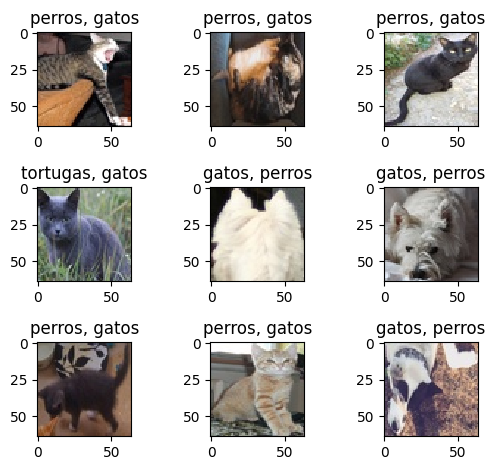

In [ ]:
incorrect = np.where(predicted_classes!=test_Y)[0]
print("Found %d incorrect labels" % len(incorrect))

for i, incorrect in enumerate(incorrect[0:9]):
    plt.subplot(3,3,i+1)
    
    plt.imshow(test_X[incorrect].reshape(64,64,3), cmap='gray', interpolation='none')
    
    plt.title("{}, {}".format(deportes[predicted_classes[incorrect]],
                                                    deportes[test_Y[incorrect]]))
    plt.tight_layout()

In [30]:
target_names = ["Class {}".format(i) for i in range(nClasses)]
print(classification_report(test_Y, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.73      0.67      0.70      2375
     Class 1       0.99      0.95      0.97      2073
     Class 2       0.99      0.98      0.99      1997
     Class 3       0.75      0.74      0.74      2737
     Class 4       0.83      0.95      0.89      2040

    accuracy                           0.85     11222
   macro avg       0.86      0.86      0.86     11222
weighted avg       0.85      0.85      0.85     11222



🔍 Buscando imágenes en la carpeta actual...
   -> Encontrada: gato prueba 2.jpg
   -> Encontrada: gato.jpg
   -> Encontrada: hormiga prueba 2.jpg
   -> Encontrada: mariquita prueba 2.jpg
   -> Encontrada: mariquita.jpg
   -> Encontrada: perro prueba 1.jpg
   -> Encontrada: perros.jpg
   -> Encontrada: prueba.jpg
   -> Encontrada: tortuga.jpg
   -> Encontrada: totugaagua.jpg

🧠 Analizando 10 imágenes...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


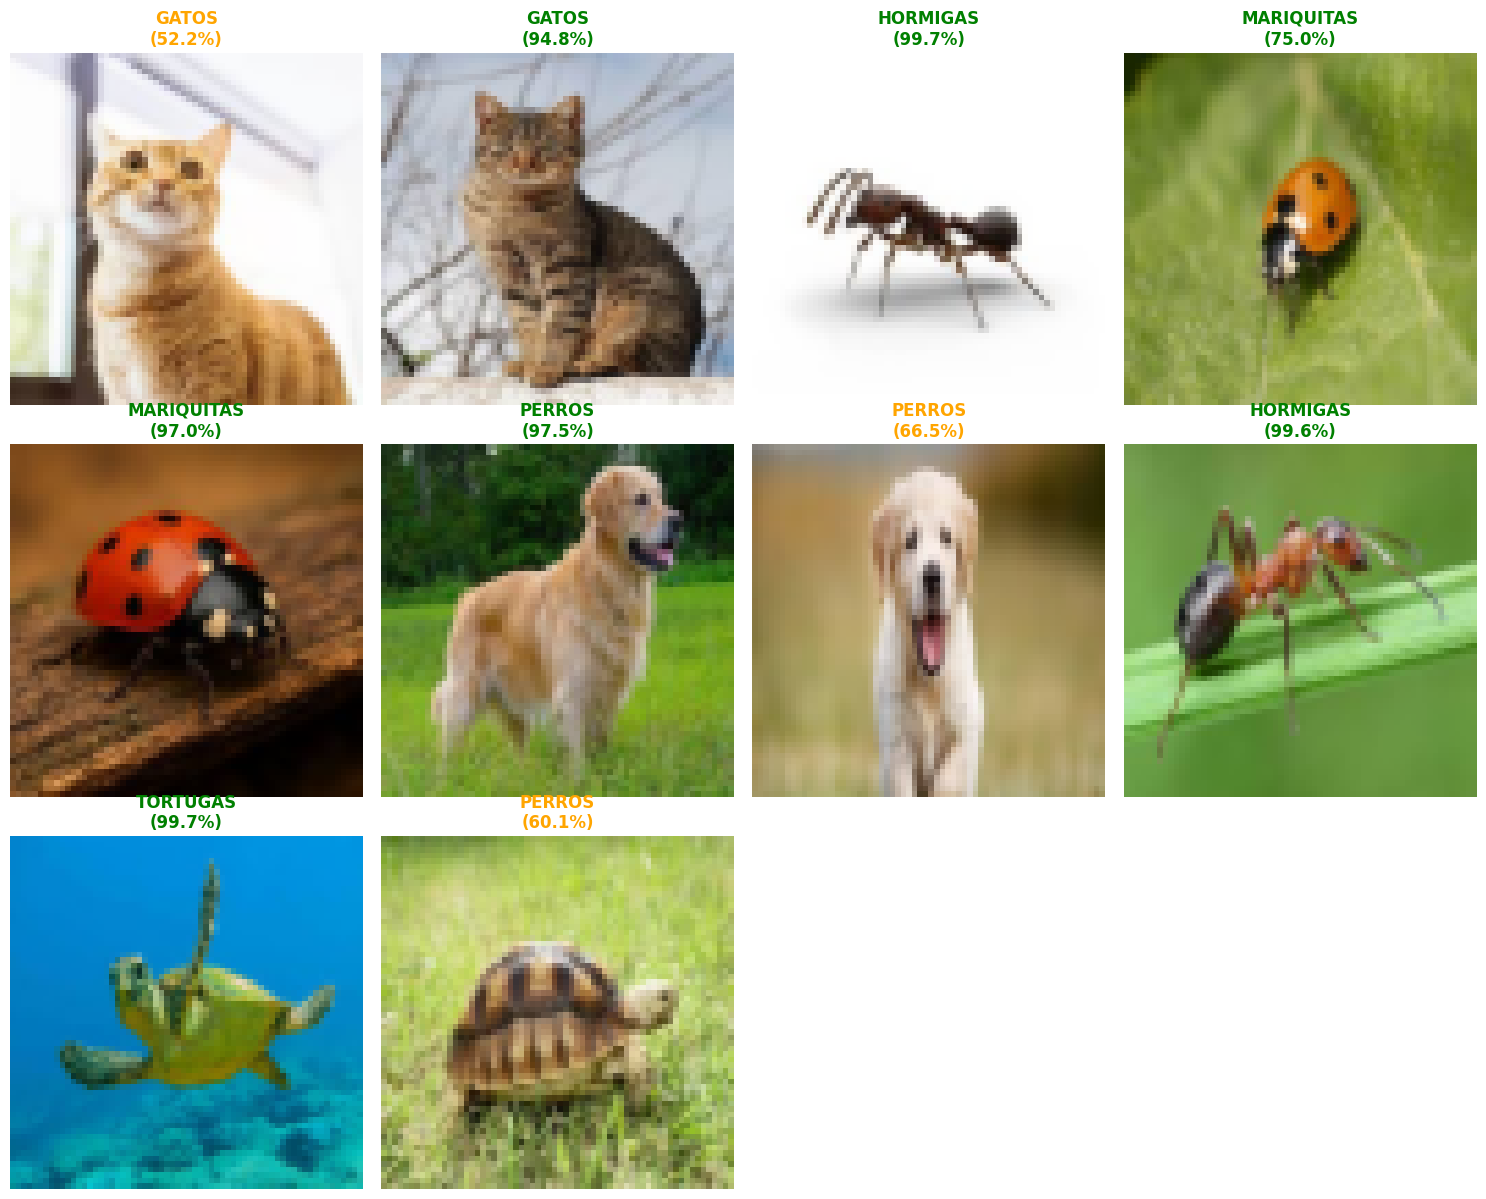

In [31]:
import os
import matplotlib.pyplot as plt
from skimage.transform import resize
import numpy as np
import math

# 1. Configuración
# Asegúrate de que estas son las clases en el orden alfabético correcto (como las carpetas)
clases = ['gatos', 'hormigas', 'mariquitas', 'perros', 'tortugas']
target_size = (64, 64)

# 2. Buscar todas las imágenes en la carpeta actual
# Filtramos para que no lea el archivo .ipynb o las carpetas del dataset
extensiones_validas = ['.jpg', '.jpeg', '.png', '.bmp']
archivos_en_carpeta = os.listdir('.')

imagenes_para_probar = []
nombres_archivos = []

print(f"🔍 Buscando imágenes en la carpeta actual...")

for archivo in archivos_en_carpeta:
    nombre, extension = os.path.splitext(archivo)
    
    # Si es una imagen (y no empieza con punto, para evitar archivos ocultos)
    if extension.lower() in extensiones_validas and not archivo.startswith('.'):
        try:
            # Leemos la imagen
            img = plt.imread(archivo)
            
            # Si la imagen tiene 4 canales (PNG con transparencia), quitamos el alfa
            if img.shape[-1] == 4:
                img = img[:, :, :3]
            
            # Redimensionamos a 64x64 (Manteniendo rango 0-255 para ser consistente con tu entrenamiento)
            img_resized = resize(img, target_size, anti_aliasing=True, preserve_range=True)
            
            imagenes_para_probar.append(img_resized)
            nombres_archivos.append(archivo)
            print(f"   -> Encontrada: {archivo}")
            
        except Exception as e:
            print(f"   ⚠️ No se pudo leer {archivo}: {e}")

# 3. Si encontramos imágenes, hacemos la predicción masiva
cantidad = len(imagenes_para_probar)

if cantidad > 0:
    # Convertir a array y normalizar (0 a 1)
    X_prueba = np.array(imagenes_para_probar).astype('float32') / 255.0
    
    # ¡PREDICCIÓN!
    print(f"\n🧠 Analizando {cantidad} imágenes...")
    predicciones = sport_model.predict(X_prueba)
    
    # 4. Mostrar resultados en una cuadrícula (Grid)
    # Calculamos filas y columnas para que se vea ordenado
    cols = 4
    rows = math.ceil(cantidad / cols)
    
    plt.figure(figsize=(15, 4 * rows))
    
    for i in range(cantidad):
        plt.subplot(rows, cols, i + 1)
        
        # Obtener la clase ganadora
        indice_ganador = np.argmax(predicciones[i])
        clase_ganadora = clases[indice_ganador]
        confianza = np.max(predicciones[i]) * 100 # Porcentaje de seguridad
        
        # Mostrar imagen
        plt.imshow(X_prueba[i])
        plt.axis('off')
        
        # Título con el resultado
        # Ponemos el título verde si la confianza es alta, amarillo si duda
        color_texto = 'green' if confianza > 70 else 'orange'
        plt.title(f"{clase_ganadora.upper()}\n({confianza:.1f}%)", color=color_texto, fontweight='bold')
        plt.xlabel(nombres_archivos[i]) # Nombre del archivo abajo

    plt.tight_layout()
    plt.show()

else:
    print("❌ No encontré imágenes .jpg o .png en esta carpeta (fuera de 'dataset').")

Generando predicciones...
281/281 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


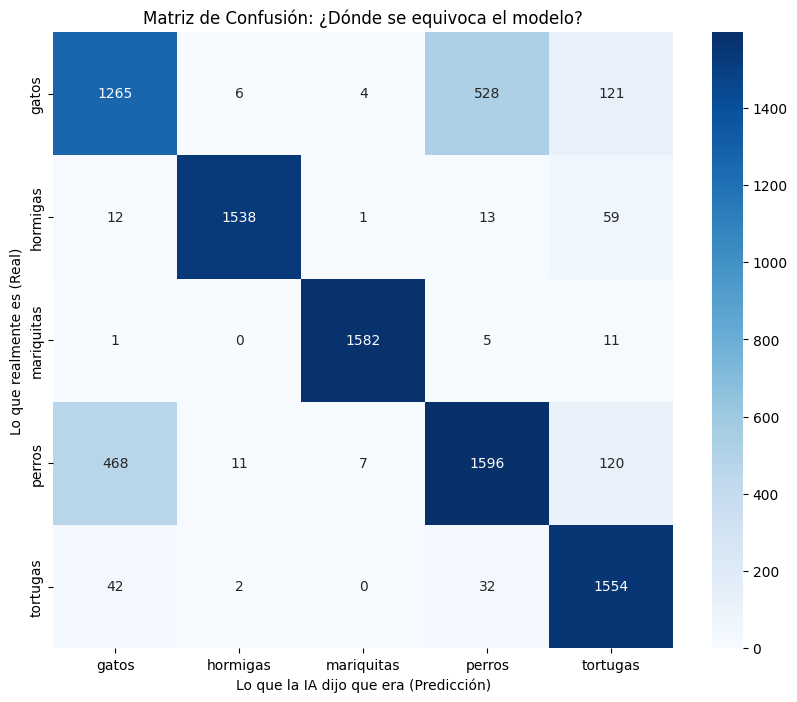


Reporte detallado por clase:
              precision    recall  f1-score   support

       gatos       0.71      0.66      0.68      1924
    hormigas       0.99      0.95      0.97      1623
  mariquitas       0.99      0.99      0.99      1599
      perros       0.73      0.72      0.73      2202
    tortugas       0.83      0.95      0.89      1630

    accuracy                           0.84      8978
   macro avg       0.85      0.85      0.85      8978
weighted avg       0.84      0.84      0.84      8978



In [32]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Hacer las predicciones sobre el conjunto de validación
print("Generando predicciones...")
Y_pred = sport_model.predict(valid_X)

# 2. Convertir de vectores 'One-Hot' (ej: [0, 0, 1, 0, 0]) a números enteros (ej: 2)
y_pred_classes = np.argmax(Y_pred, axis=1) 
y_true = np.argmax(valid_label, axis=1)

# 3. Crear la Matriz de Confusión
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# 4. Graficarla bonita con un mapa de calor
plt.figure(figsize=(10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
            xticklabels=deportes, yticklabels=deportes)
plt.ylabel('Lo que realmente es (Real)')
plt.xlabel('Lo que la IA dijo que era (Predicción)')
plt.title('Matriz de Confusión: ¿Dónde se equivoca el modelo?')
plt.show()

# 5. Imprimir el reporte con porcentajes detallados
print('\nReporte detallado por clase:')
print(classification_report(y_true, y_pred_classes, target_names=deportes))